In [2]:
import os
import math
import requests
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

#### Functions

In [3]:
# Function adding independent Month, Day, Hour, Minute, Day of week columns from the date/time index to the dataframe

def timeValues(*arg):
    
    days = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}
    
    for x in list(arg):
        x["Month"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.month))
        
        x["Day"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.day))
        
        x["Hour"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.hour))
        
        x["Minute"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.minute))
        
        x["Day of Week"] = list(x.reset_index()["Date/Time"].apply(lambda x: days[x.dayofweek]))

In [4]:
#Converting data types to floats

def convert(num):
    try:
        return(float(num))
    except:
        return(np.nan)

In [5]:
#Assign binary code to row whether the date/time falls on a school day or not, 1 = School day, 0 = Day off

def daysoff(df):
    daysoff = [
        datetime.date(2016,10,8),datetime.date(2016,10,9),datetime.date(2016,10,15),datetime.date(2016,10,16),
        datetime.date(2016,10,22),datetime.date(2016,10,23),datetime.date(2016,10,29),datetime.date(2016,10,30),
        datetime.date(2016,11,5),datetime.date(2016,11,6),datetime.date(2016,11,10),datetime.date(2016,11,11),
        datetime.date(2016,11,12),datetime.date(2016,11,13),datetime.date(2016,11,19),datetime.date(2016,11,20),
        datetime.date(2016,11,21),datetime.date(2016,11,22),datetime.date(2016,11,23),datetime.date(2016,11,24),
        datetime.date(2016,11,25),datetime.date(2016,11,26),datetime.date(2016,11,27),datetime.date(2016,12,3),
        datetime.date(2016,12,4),datetime.date(2016,12,10),datetime.date(2016,12,11),datetime.date(2016,12,17),
        datetime.date(2016,12,18),datetime.date(2016,12,22),datetime.date(2016,12,23),datetime.date(2016,12,24),
        datetime.date(2016,12,25),datetime.date(2016,12,26),datetime.date(2016,12,27),datetime.date(2016,12,28),
        datetime.date(2016,12,29),datetime.date(2016,12,30),datetime.date(2016,12,31),datetime.date(2017,1,1),
        datetime.date(2017,1,2),datetime.date(2017,1,3),datetime.date(2017,1,7),datetime.date(2017,1,8),
        datetime.date(2017,1,14),datetime.date(2017,1,15),datetime.date(2017,1,16)
    ]

    schoolDays = []
    for x in df.index:
        if x.date() in daysoff:
            schoolDays.append(0)
        else:
            schoolDays.append(1)

    schoolHours = []
    for x in df.index:
        if datetime.time(7,45) <= x.time() and x.time() <= datetime.time(15,15):
            schoolHours.append(1)
        else:
            schoolHours.append(0)

    df["School Day"] = schoolDays
    df["School Hours"] = schoolHours

### Question #2

### AHU vs PMV Correlation

#### Energy Data SQL Query

In [6]:
cursor.execute("SELECT * FROM sibonienergy;")
energy = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Month", "Day", "Hour", "Minute", "Day of Week",
                                                 "ID", "School Day", "School Hour", "Pulse", "kW", "kWh"])

energy.set_index("Date/Time" ,inplace = True)
energy["Pulse"] = energy["Pulse"].apply(lambda x: convert(x))
energy["kW"] = energy["kW"].apply(lambda x: convert(x))
energy["kWh"] = energy["kWh"].apply(lambda x: convert(x))

In [7]:
date = []
for x in energy.reset_index()["Date/Time"]:
    date.append(x.date())

energy["Date"] = date

#### Hourly AHU Energy Usage

In [7]:
hourAHU = pd.DataFrame(energy[energy["ID"] == "Air Handling Unit"].groupby(["Date", "Hour"])["kWh"].sum()).reset_index()

dateHolder = []
for date, hour in zip(hourAHU["Date"], hourAHU["Hour"]):
    hour = datetime.datetime.strptime(str(hour), "%H").time()
    dateHolder.append(datetime.datetime.combine(date,hour))
    
hourAHU["Date/Time"] = dateHolder
hourAHU.set_index("Date/Time", inplace = True)
hourAHU.drop(["Date", "Hour"], axis = 1, inplace = True)
timeValues(hourAHU)

#### PMV Data 

In [142]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Raw PMV Data All Days")
pmvData = pd.read_excel("Full Raw All Days PMV Data.xlsx", index_col = 0)

In [143]:
hourPMV = pmvData.groupby(pd.TimeGrouper(freq = "1H")).mean()

#### AHU Energy Usage Disaggregation

In [11]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Energy Usage/Outputs")
disaggKey = pd.read_excel("Energy Disaggregation Key.xlsx")

In [146]:
# From the % of sqft each room 5216 and 5218 repectively took up from the AHU multiplied by the total kWh used each hour

ahu5216 = pd.DataFrame(float(disaggKey[disaggKey["Room"] == "5216"]["AHU %"]) * hourAHU["kWh"])
ahu5218 = pd.DataFrame(float(disaggKey[disaggKey["Room"] == "5218"]["AHU %"]) * hourAHU["kWh"])

#### AHU Energy Use and PMV Merge

In [147]:
# Joined the hourly kWh use to the hourly PMV average

scatter5216 = pd.DataFrame(hourPMV["5216"]).join(ahu5216, how = "outer").dropna()
scatter5218 = pd.DataFrame(hourPMV["5218"]).join(ahu5218, how = "outer").dropna()

scatter5216.columns = ["PMV", "kWh"]
scatter5218.columns = ["PMV", "kWh"]

#### KBTU Calculation

In [148]:
scatter5216["KBTU"] = scatter5216["kWh"] * 3.4121416331
scatter5218["KBTU"] = scatter5218["kWh"] * 3.4121416331

#### School Days and School Hours?

In [149]:
for x in [scatter5216, scatter5218]:
    daysoff(x)

### Hourly AHU Energy Use vs PMV Value Scatter Plot

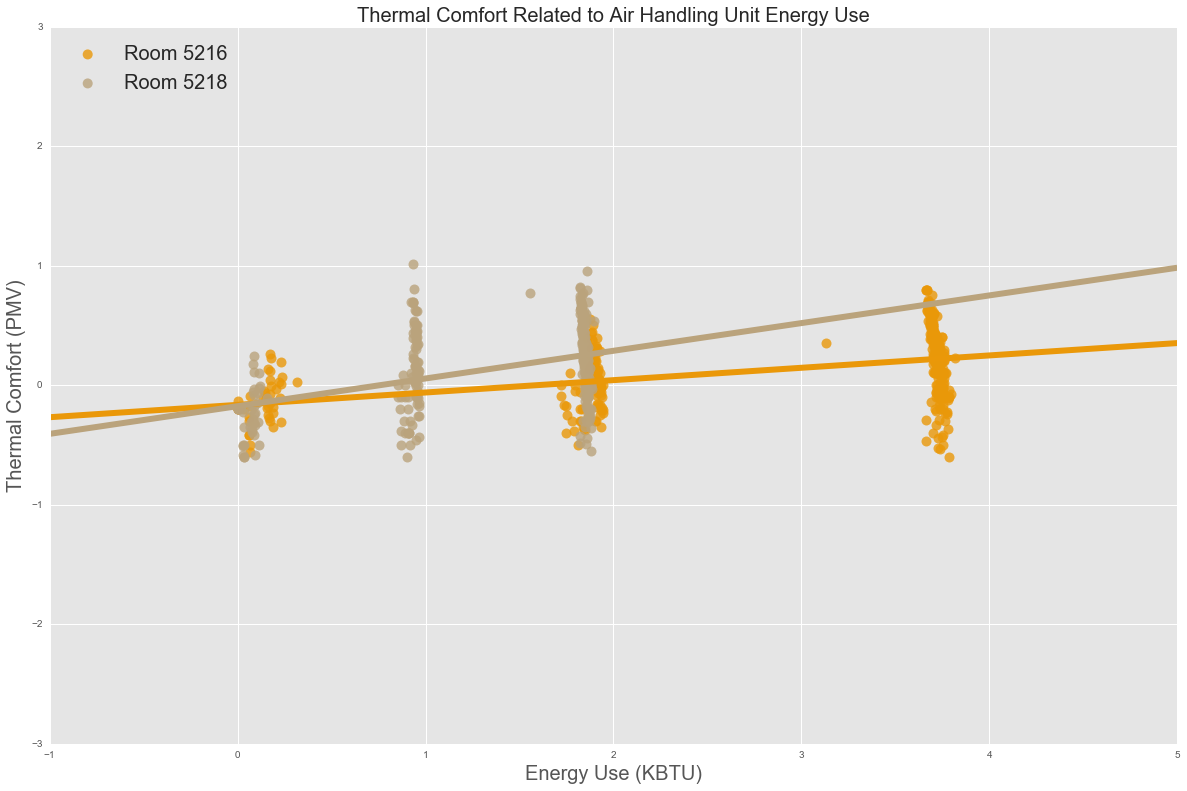

In [150]:
plt.style.use("ggplot")
pmvScatterFig = plt.figure(figsize = (18,12))

sns.regplot(x = scatter5216[(scatter5216["School Day"] == 1) & (scatter5216["School Hours"] == 1)]["KBTU"],
           y = scatter5216[(scatter5216["School Day"] == 1) & (scatter5216["School Hours"] == 1)]["PMV"],
           color = "#ea9809", label = "Room 5216", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = scatter5218[(scatter5218["School Day"] == 1) & (scatter5218["School Hours"] == 1)]["KBTU"],
           y = scatter5218[(scatter5218["School Day"] == 1) & (scatter5218["School Hours"] == 1)]["PMV"],
           color = "#baa37c", label = "Room 5218", scatter_kws={'s':100}, ci = 0)

sns.plt.ylim(-3,3)
plt.xlabel("Energy Use (KBTU)", fontdict = {"size" : 20})
plt.ylabel("Thermal Comfort (PMV)", fontdict = {"size" : 20})
plt.title("Thermal Comfort Related to Air Handling Unit Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

### AHU KBTU/Sqft vs PMV Scatter Plot

In [228]:
# Calculate kWh use by hour

ahuTotal = pd.DataFrame(energy[energy["ID"] == "Air Handling Unit"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
# panel9 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 9"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
# panel15 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 15"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())

# Calculate total Square footage covered by each Panel

sqftAHU = 102 + 118 + 825 + 410
# sqftPanel9 = 477 + 102 + 118 + 825
# sqftPanel15 = 215 + 228 + 170 + 59 + 61 + 410 + 512 + 50 + 58 + 185

# Calculate KBTU/Square footage from KWh and total squarefootage covered by AHU or lighting panel

ahuTotal["KBTU/Sqft"] = (ahuTotal["kWh"] * 3.4121416331) / sqftAHU
# panel9["KBTU/Sqft"] = (panel9["kWh"] * 3.4121416331) / sqftPanel9
# panel15["KBTU/Sqft"] = (panel15["kWh"] * 3.4121416331) / sqftPanel15

In [235]:
pmvScatter5216 = pd.DataFrame(hourPMV["5216"]).join(ahuTotal).dropna()
pmvScatter5218 = pd.DataFrame(hourPMV["5218"]).join(ahuTotal).dropna()

In [236]:
for x in [pmvScatter5216, pmvScatter5218]:
    daysoff(x)

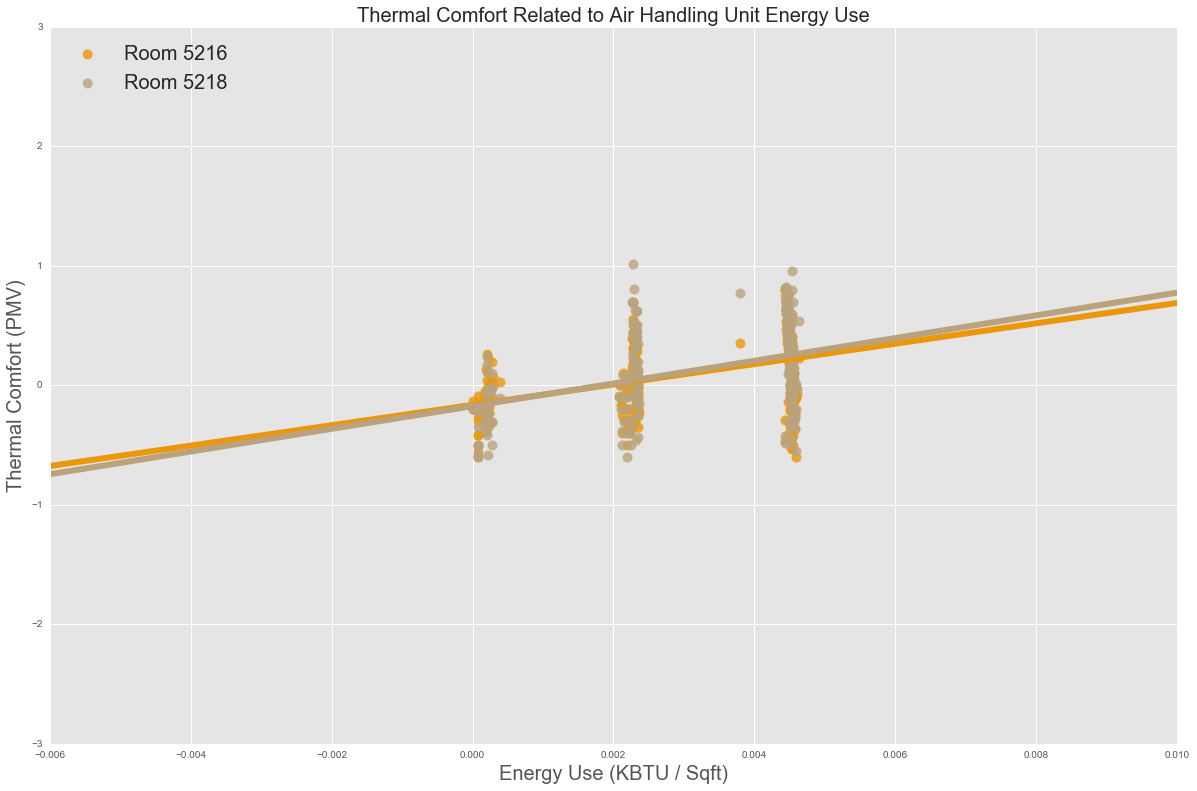

In [242]:
plt.style.use("ggplot")
pmvScatterFig = plt.figure(figsize = (18,12))

sns.regplot(x = pmvScatter5216[(pmvScatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["KBTU/Sqft"],
           y = pmvScatter5216[(pmvScatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["5216"],
           color = "#ea9809", label = "Room 5216", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["KBTU/Sqft"],
           y = pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["5218"],
           color = "#baa37c", label = "Room 5218", scatter_kws={'s':100}, ci = 0)

sns.plt.ylim(-3,3)
plt.xlabel("Energy Use (KBTU / Sqft)", fontdict = {"size" : 20})
plt.ylabel("Thermal Comfort (PMV)", fontdict = {"size" : 20})
plt.title("Thermal Comfort Related to Air Handling Unit Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

In [515]:
# Calculate the percentage of scatter data points (PMV) fall within specified benchmarks

# only counting datapoints in the first two energy setting levels

count = pmvScatter5218[(pmvScatter5218["KBTU/Sqft"] > .004) &
#                 (pmvScatter5218["KBTU/Sqft"] <= .004) &
               (pmvScatter5218["School Day"] == 1) & 
               (pmvScatter5218["School Hours"] == 1)]["5218"].count()
cold = 0
ok = 0
hot = 0
for x in pmvScatter5218[(pmvScatter5218["KBTU/Sqft"] > .004) & 
#                 (pmvScatter5218["KBTU/Sqft"] <= .004) &
               (pmvScatter5218["School Day"] == 1) & 
               (pmvScatter5218["School Hours"] == 1)]["5218"]:
    if x < -.5:
        cold += 1
    elif x > .5:
        hot += 1
    elif x <= .5 and x >= -.5:
        ok += 1


print("5218")
print(count)
print("Too Cold: ", (cold/count))
print("Good: ", (ok/count))
print("Too Hot: ", (hot/count))

5218
235
Too Cold:  0.00425531914894
Good:  0.821276595745
Too Hot:  0.174468085106


In [349]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Two")
pmvScatter5216.to_excel("Thermal Comfort vs AHU 5216.xlsx")
pmvScatter5218.to_excel("Thermal Comfort vs AHU 5218.xlsx")

In [457]:
# Calculate the percentage of scatter data points (PMV) fall within specified benchmarks

count = len(pmvScatter5216[(scatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["5216"].dropna())
cold = 0
ok = 0
hot = 0
for x in pmvScatter5216[(pmvScatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["5216"].dropna():
    if x < -.5:
        cold += 1
    elif x > .5:
        hot += 1
    elif x <= .5 and x >= -.5:
        ok += 1

print("5216")
print(count)
print("Too Cold: ", (cold/count))
print("Good: ", (ok/count))
print("Too Hot: ", (hot/count))
    

5216
366
Too Cold:  0.01092896174863388
Good:  0.8825136612021858
Too Hot:  0.10655737704918032


In [458]:
# Calculate the percentage of scatter data points (PMV) fall within specified benchmarks

count = len(pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["5218"].dropna())
cold = 0
ok = 0
hot = 0
for x in pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["5218"].dropna():
    if x < -.5:
        cold += 1
    elif x > .5:
        hot += 1
    elif x <= .5 and x >= -.5:
        ok += 1

print("5218")
print(count)
print("Too Cold: ", (cold/count))
print("Good: ", (ok/count))
print("Too Hot: ", (hot/count))
    

5218
366
Too Cold:  0.01912568306010929
Good:  0.8360655737704918
Too Hot:  0.1448087431693989


In [578]:
# Calculate the percentage of scatter data points (KBTU/Sqft) fall within specified benchmarks

count = len(pmvScatter5216[(pmvScatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["KBTU/Sqft"].dropna())
low = 0
mid = 0
high = 0
for x in pmvScatter5216[(pmvScatter5216["School Day"] == 1) & (pmvScatter5216["School Hours"] == 1)]["KBTU/Sqft"].dropna():
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5216")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))

print(low, mid, high)

5216
Low:  0.11475409836065574
Mid:  0.24316939890710382
High:  0.6420765027322405
42 89 235


In [579]:
# Calculate the percentage of scatter data points (KBTU/Sqft) fall within specified benchmarks

count = len(pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["KBTU/Sqft"].dropna())
low = 0
mid = 0
high = 0
for x in pmvScatter5218[(pmvScatter5218["School Day"] == 1) & (pmvScatter5218["School Hours"] == 1)]["KBTU/Sqft"].dropna():
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5218")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))

print(low, mid, high)

5218
Low:  0.11475409836065574
Mid:  0.24316939890710382
High:  0.6420765027322405
42 89 235


In [66]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Question Two")
scatter5216.to_excel("Thermal Comfort vs AHU 5216.xlsx")
scatter5218.to_excel("Thermal Comfort vs AHU 5218.xlsx")

In [17]:
# calculate R squared values from PMV/AHU use scatter plot

from scipy import stats
print("5216 PMV vs AHU: ", stats.linregress(x = scatter5216[(scatter5216["School Day"] == 1) & (scatter5216["School Hours"] == 1)]["KBTU"],
                 y = scatter5216[(scatter5216["School Day"] == 1) & (scatter5216["School Hours"] == 1)]["PMV"])[2]**2)
print(" ")
print("5218 PMV vs AHU: ", stats.linregress(x = scatter5218[(scatter5218["School Day"] == 1) & (scatter5218["School Hours"] == 1)]["KBTU"],
                 y = scatter5218[(scatter5218["School Day"] == 1) & (scatter5218["School Hours"] == 1)]["PMV"])[2]**2)

5216 PMV vs AHU:  0.188624970027
 
5218 PMV vs AHU:  0.183429859251


### AHU vs Air Quality Correlation

#### Air Quality (CO2) SQL Query

In [243]:
cursor.execute("SELECT date_time, month, day, hour, minute, school_day, school_hours, room, co2 FROM sibonidata")
airData = pd.DataFrame(data = cursor.fetchall(), 
                       columns = ["Date/Time", "Month", "Day", "Hour", "Minute", 
                                  "School Day", "School Hour", "Room", "CO2"])

airData["CO2"] = airData["CO2"].apply(lambda x: convert(x))

In [244]:
cursor.execute("SELECT date_time, month, day, hour, minute, school_day, school_hours, room, co2 FROM sibonidata WHERE room = '5216';")
air5216 = pd.DataFrame(data = cursor.fetchall(), 
                       columns = ["Date/Time", "Month", "Day", "Hour", "Minute", 
                                  "School Day", "School Hour", "Room", "CO2"])

air5216["CO2"] = air5216["CO2"].apply(lambda x: convert(x))

In [245]:
cursor.execute("SELECT date_time, month, day, hour, minute, school_day, school_hours, room, co2 FROM sibonidata WHERE room = '5218';")
air5218 = pd.DataFrame(data = cursor.fetchall(), 
                       columns = ["Date/Time", "Month", "Day", "Hour", "Minute", 
                                  "School Day", "School Hour", "Room", "CO2"])

air5218["CO2"] = air5218["CO2"].apply(lambda x: convert(x))

#### Hourly Air Quality Data

In [182]:
# Calculate average raw hourly average air quality 

date5216 = []
date5218 = []
for x in ["5216", "5218"]:
    for y in airData[airData["Room"] == x]["Date/Time"]:
        if x == "5216":
            date5216.append(y.date())
        else:
            date5218.append(y.date())

air5216["Date"] = date5216
air5218["Date"] = date5218

air5216 = air5216.groupby(["Date", "Hour"])["CO2"].mean().reset_index()
air5218 = air5218.groupby(["Date", "Hour"])["CO2"].mean().reset_index()

In [15]:
def datetimer(dateList, hourList):
    dateHolder = []
    for date, hour in zip(dateList, hourList):
        hour = datetime.datetime.strptime(str(hour), "%H").time()
        dateHolder.append(datetime.datetime.combine(date,hour))
    
    return(dateHolder)

air5216["Date/Time"] = datetimer(air5216["Date"], air5216["Hour"])
air5218["Date/Time"] = datetimer(air5218["Date"], air5218["Hour"])

air5216.set_index("Date/Time", inplace = True)
air5218.set_index("Date/Time", inplace = True)

air5216.drop(["Date", "Hour"], axis = 1, inplace = True)
air5218.drop(["Date", "Hour"], axis = 1, inplace = True)

timeValues(air5216)
timeValues(air5218)

In [184]:
air5216 = pd.concat([air5216.ix["2016-12-16"], air5216.ix["2017-1-11"], air5216.ix["2017-1-12"]], axis = 0)

#### AHU Energy Unit and Air Quality Data Merge

In [185]:
airScatter5216 = ahu5216.join(air5216, how = 'outer').dropna()
airScatter5218 = ahu5218.join(air5218, how = 'outer').dropna()

#### KBTU Calc

In [186]:
airScatter5216["KBTU"] = airScatter5216["kWh"] * 3.4121416331
airScatter5218["KBTU"] = airScatter5218["kWh"] * 3.4121416331

#### School day and School Hours?

In [187]:
for x in [airScatter5216, airScatter5218]:
    daysoff(x)

### Hourly AHU Energy Usage vs Air Quality Scatter Plot

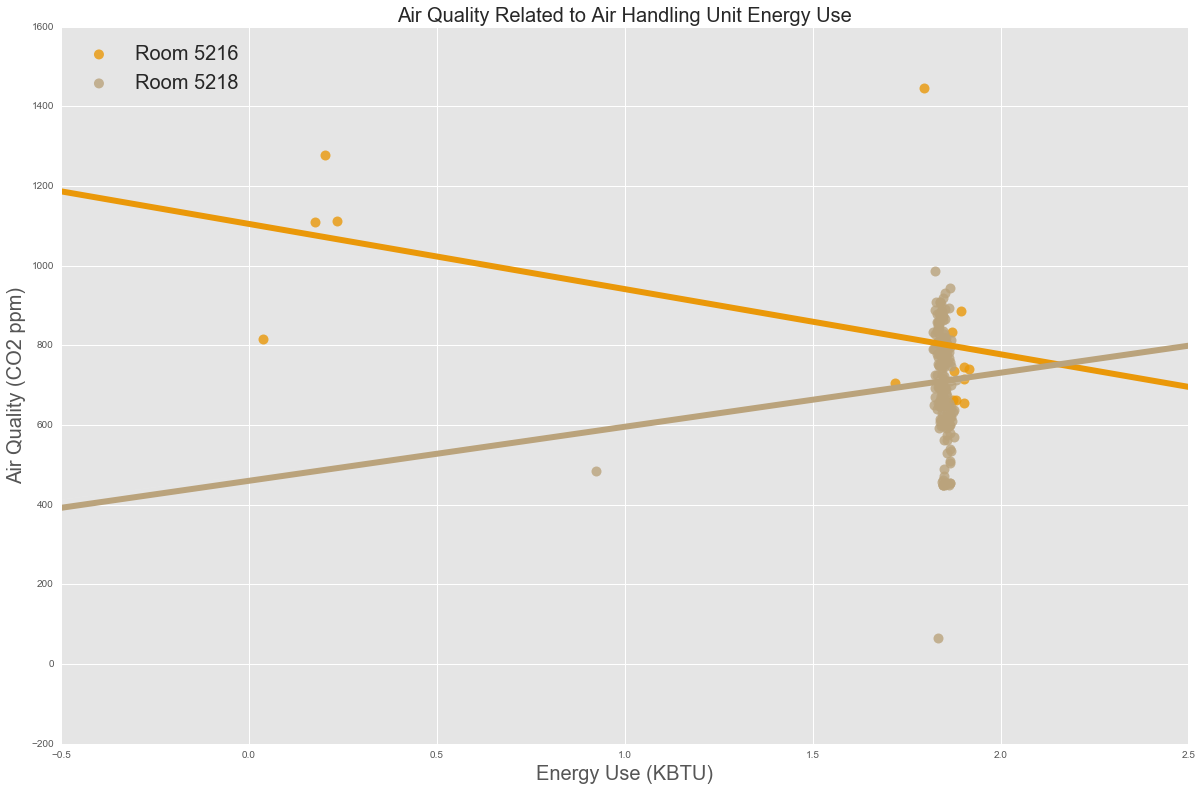

In [188]:
plt.style.use("ggplot")
airScatterFig = plt.figure(figsize = (18,12))

sns.regplot(x = airScatter5216[(airScatter5216["School Day"] == 1) & (airScatter5216["School Hours"] == 1) &
                              (airScatter5216["CO2"] > 200)]["KBTU"],
           y = airScatter5216[(airScatter5216["School Day"] == 1) & (airScatter5216["School Hours"] == 1) & 
                             (airScatter5216["CO2"] > 200)]["CO2"],
           color = "#ea9809", label = "Room 5216", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = airScatter5218[(airScatter5218["School Day"] == 1) & (airScatter5218["School Hours"] == 1) & 
                              (airScatter5218["CO2"] > 0)]["KBTU"],
           y = airScatter5218[(airScatter5218["School Day"] == 1) & (airScatter5218["School Hours"] == 1) & 
                              (airScatter5218["CO2"] > 0)]["CO2"],
           color = "#baa37c", label = "Room 5218", scatter_kws={'s':100}, ci = 0)


# sns.plt.ylim(-30,2000)
# sns.plt.xlim(.5,4)
plt.xlabel("Energy Use (KBTU)", fontdict = {"size" : 20})
plt.ylabel("Air Quality (CO2 ppm)", fontdict = {"size" : 20})
plt.title("Air Quality Related to Air Handling Unit Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

In [80]:
print("5216 CO2 vs AHU: ", stats.linregress(
        x = airScatter5216[(airScatter5216["School Day"] == 1) & (airScatter5216["School Hours"] == 1) &
                              (airScatter5216["CO2"] > 200)]["KBTU"],
        y = airScatter5216[(airScatter5216["School Day"] == 1) & (airScatter5216["School Hours"] == 1) & 
                             (airScatter5216["CO2"] > 200)]["CO2"])[2] ** 2)
print(" ")
print("5218 CO2 vs AHU: ", stats.linregress(
        x = airScatter5218[(airScatter5218["School Day"] == 1) & (airScatter5218["School Hours"] == 1) & 
                              (airScatter5218["CO2"] > 200)]["KBTU"],
        y = airScatter5218[(airScatter5218["School Day"] == 1) & (airScatter5218["School Hours"] == 1) &
                             (airScatter5218["CO2"] > 200)]["CO2"])[2] ** 2)

5216 CO2 vs AHU:  0.268972580688
 
5218 CO2 vs AHU:  0.00546034862625


In [721]:
energyAirQuality = airScatter5216.join(airScatter5218[["KBTU", "CO2", "kWh"]], how = "outer", rsuffix = " 5218")

energyAirQuality = energyAirQuality[(energyAirQuality["School Day"] == 1) & (energyAirQuality["School Hours"] == 1) &
                                   (energyAirQuality["CO2"] > 100) & (energyAirQuality["CO2 5218"] > 100)]

### Circuit Energy Use/SqFt vs CO2 ppm

#### Panel 9 / 5216

In [247]:
air5216.set_index("Date/Time", inplace = True)
air5218.set_index("Date/Time", inplace = True)
air5216 = pd.concat([air5216.ix["2016-12-16"], air5216.ix["2017-01-11"], air5216.ix["2017-01-12"]])

In [252]:
hourAir5216 = air5216.groupby(pd.TimeGrouper(freq = "1H"))["CO2"].mean()
hourAir5218 = air5218.groupby(pd.TimeGrouper(freq = "1H"))["CO2"].mean()

In [249]:
# calculate hourly lighting energy use for AHU, Panel 9 and Panel 15

# ahuTotal = pd.DataFrame(energy[energy["ID"] == "Air Handling Unit"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
panel9 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 9"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
panel15 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 15"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())

# Total sqft covered by AHU, Panel 9 and Panel 15

# sqftAHU = 102 + 118 + 825 + 410
sqftPanel9 = 477 + 102 + 118 + 825
sqftPanel15 = 215 + 228 + 170 + 59 + 61 + 410 + 512 + 50 + 58 + 185

# Calculate KBTU/Sqft from kWh and sqft covered

# ahuTotal["KBTU/Sqft"] = (ahuTotal["kWh"] * 3.4121416331) / sqftAHU
panel9["KBTU/Sqft"] = (panel9["kWh"] * 3.4121416331) / sqftPanel9
panel15["KBTU/Sqft"] = (panel15["kWh"] * 3.4121416331) / sqftPanel15

In [348]:
# timeValues(ahuTotal)
pd.DataFrame(ahuTotal[ahuTotal["kWh"] < .035].dropna().groupby("Hour")["Hour"].count().sort_values(ascending = False))

,Hour
Hour,
1,60
2,60
3,60
5,59
4,59
23,54
0,54
6,43
22,42


In [300]:
# Merge hourly air handling unit use and average air quality

co2Scatter5216 = pd.DataFrame(hourAir5216).join(ahuTotal, how = "inner").dropna()
co2Scatter5218 = pd.DataFrame(hourAir5218).join(ahuTotal, how = "inner").dropna()

for x in [co2Scatter5216, co2Scatter5218]:
    daysoff(x)

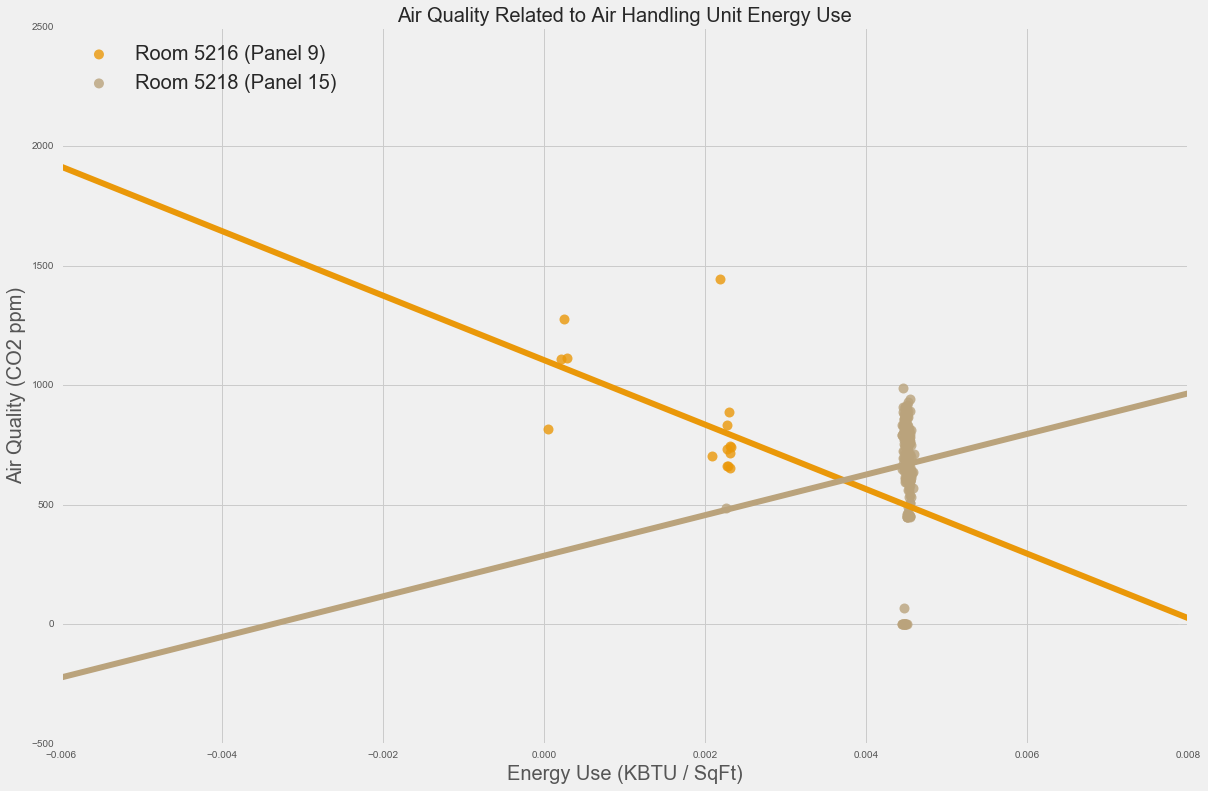

In [302]:
plt.style.use("fivethirtyeight")
testFig = plt.figure(figsize = (18,12))

sns.regplot(x = co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["KBTU/Sqft"],
            y = co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["CO2"], 
            color = "#ea9809", label = "Room 5216 (Panel 9)", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["KBTU/Sqft"],
            y = co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["CO2"], 
            color = "#baa37c", label = "Room 5218 (Panel 15)", scatter_kws={'s':100}, ci = 0)


# sns.plt.ylim(-100,2000)
# sns.plt.xlim(-.0002,.005)

plt.xlabel("Energy Use (KBTU / SqFt)", fontdict = {"size" : 20})
plt.ylabel("Air Quality (CO2 ppm)", fontdict = {"size" : 20})
plt.title("Air Quality Related to Air Handling Unit Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

In [553]:
len(co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["KBTU/Sqft"])

15

In [577]:
# Calculate the percentage of time air handling unit energy use falls within specified theresholds 

holder = co2Scatter5218[(co2Scatter5218["School Day"] == 1) & 
    (co2Scatter5218["School Hours"] == 1)]["KBTU/Sqft"]

count = len(holder)
low = 0
mid = 0
high = 0
for x in holder:
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5218")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))
print(low, mid, high)

5218
Low:  0.0
Mid:  0.005319148936170213
High:  0.9946808510638298
0 1 187


In [470]:
# Calculate the percentage of time air quality falls within specified theresholds 

count = len(co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["CO2"].dropna())
cold = 0
ok = 0
hot = 0
for x in co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["CO2"].dropna():
    if x < 500:
        cold += 1
    elif x > 1100:
        hot += 1
    elif x <= 1100 and x >= 500:
        ok += 1

print("5216")
print(count)
print("Exceptional: ", (cold/count))
print("Adequate: ", (ok/count))
print("Poor: ", (hot/count))
print(cold,)

5216
15
Exceptional:  0.0
Adequate:  0.7333333333333333
Poor:  0.26666666666666666


In [471]:
# Calculate the percentage of time air quality falls within specified theresholds 

count = len(co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["CO2"].dropna())
cold = 0
ok = 0
hot = 0
for x in co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["CO2"].dropna():
    if x < 500:
        cold += 1
    elif x > 1100:
        hot += 1
    elif x <= 1100 and x >= 500:
        ok += 1

print("5218")
print(count)
print("Exceptional: ", (cold/count))
print("Adequate: ", (ok/count))
print("Poor: ", (hot/count))

5218
188
Exceptional:  0.13297872340425532
Adequate:  0.8670212765957447
Poor:  0.0


In [556]:
# Calculate the percentage of time air handling unit energy use falls within specified theresholds 

count = len(co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["KBTU/Sqft"].dropna())
low = 0
mid = 0
high = 0
for x in co2Scatter5216[(co2Scatter5216["School Day"] == 1) & (co2Scatter5216["School Hours"] == 1)]["KBTU/Sqft"].dropna():
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5216")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))

print(low, mid, high)

5216
Low:  0.26666666666666666
Mid:  0.7333333333333333
High:  0.0
4 11 0


In [473]:
# Calculate the percentage of time air handling unit energy use falls within specified theresholds 

count = len(co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["KBTU/Sqft"].dropna())
low = 0
mid = 0
high = 0
for x in co2Scatter5218[(co2Scatter5218["School Day"] == 1) & (co2Scatter5218["School Hours"] == 1)]["KBTU/Sqft"].dropna():
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5216")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))

5216
Low:  0.0
Mid:  0.005319148936170213
High:  0.9946808510638298


In [350]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Two")
co2Scatter5216.to_excel("Air Quality vs AHU 5216.xlsx")
co2Scatter5218.to_excel("Air Quality vs AHU 5218.xlsx")

### Lighting Energy Use vs Illuminance Levels

#### Panel 9 Lighting Energy (5210, 5216)

#### Panel 15 Lighting Energy (5218)

In [8]:
panel9 = energy[energy["ID"] == "Lighting Panel 9"]
panel15 = energy[energy["ID"] == "Lighting Panel 15"]

In [23]:
light5210 = pd.DataFrame(panel9.groupby(["Date", "Hour"])["kWh"].sum()).reset_index()
light5216 = pd.DataFrame(panel9.groupby(["Date", "Hour"])["kWh"].sum()).reset_index()

light5218 = pd.DataFrame(panel15.groupby(["Date", "Hour"])["kWh"].sum()).reset_index()

#### Energy Usage disaggregated to rooms by square footage

In [24]:
light5210["kWh"] = light5210["kWh"] * float(disaggKey[disaggKey["Room"] == "5210"]["Panel 9 %"])
light5216["kWh"] = light5216["kWh"] * float(disaggKey[disaggKey["Room"] == "5216"]["Panel 9 %"])

light5218["kWh"] = light5218["kWh"] * float(disaggKey[disaggKey["Room"] == "5218"]["Panel 15 %"])

#### Hourly Energy Usage

In [25]:
light5210["Date/Time"] = datetimer(light5210["Date"], light5210["Hour"])
light5216["Date/Time"] = datetimer(light5216["Date"], light5216["Hour"])

light5218["Date/Time"] = datetimer(light5218["Date"], light5218["Hour"])

light5210.drop(["Date", "Hour"], axis = 1, inplace = True)
light5216.drop(["Date", "Hour"], axis = 1, inplace = True)

light5218.drop(["Date", "Hour"], axis = 1, inplace = True)

light5210.set_index("Date/Time", inplace = True)
light5216.set_index("Date/Time", inplace = True)

light5218.set_index("Date/Time", inplace = True)

light5210["KBTU"] = light5210["kWh"] * 3.4121416331
light5216["KBTU"] = light5216["kWh"] * 3.4121416331

light5218["KBTU"] = light5218["kWh"] * 3.4121416331

timeValues(light5210)
timeValues(light5216)

timeValues(light5218)

#### Either Light on or off

In [26]:
cursor.execute("SELECT date_time, hour, room, either_light_on FROM sibonidata WHERE room = '5210' OR room = '5216' OR room = '5218'")
eitherLight = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Hour", "Room", "Either Light On"])
eitherLight["Either Light On"] = eitherLight["Either Light On"].apply(lambda x: convert(x))
eitherLight["Date"] = eitherLight["Date/Time"].apply(lambda x: x.date())

eitherLight5210 = eitherLight[eitherLight["Room"] == "5210"].groupby(
    ["Date", "Hour"])["Either Light On"].sum().reset_index()

eitherLight5216 = eitherLight[eitherLight["Room"] == "5216"].groupby(
    ["Date", "Hour"])["Either Light On"].sum().reset_index()

eitherLight5218 = eitherLight[eitherLight["Room"] == "5218"].groupby(
    ["Date", "Hour"])["Either Light On"].sum().reset_index()

eitherLight5210["Date/Time"] = datetimer(eitherLight5210["Date"], eitherLight5210["Hour"])
eitherLight5216["Date/Time"] = datetimer(eitherLight5216["Date"], eitherLight5216["Hour"])
eitherLight5218["Date/Time"] = datetimer(eitherLight5218["Date"], eitherLight5218["Hour"])

In [27]:
# Function to add binary columns indecating weather the lights were on at least 40 minutes of the hour

def lighton(df):
    holder = []
    for x in df["Either Light On"]:
        if x > 8:
            holder.append(1)
        else:
            holder.append(0)
    
    df["40+ of Light"] = holder
    
for x in [eitherLight5210, eitherLight5216, eitherLight5218]:
    lighton(x)
    
for x in [eitherLight5210, eitherLight5216, eitherLight5218]:
    x.set_index("Date/Time", inplace = True)

In [21]:
# light5210 = []
# light5216 = []
# light5218 = []

In [28]:
light5210 = light5210.join(pd.DataFrame(eitherLight5210["40+ of Light"]), how = "left")
light5216 = light5216.join(pd.DataFrame(eitherLight5216["40+ of Light"]), how = "left")
light5218 = light5218.join(pd.DataFrame(eitherLight5218["40+ of Light"]), how = "left")

#### School Days and School Hours

In [29]:
for x in [light5210, light5216, light5218]:
    daysoff(x)

#### Illumanance by Hour

In [30]:
cursor.execute("SELECT date_time, hour, room, illum, second_illum FROM sibonidata WHERE room = '5210';")
illum5210 = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Hour", "Room", "Illum", "Second Illum"])

illum5210["Illum"] = illum5210["Illum"].apply(lambda x: convert(x)) 
illum5210["Second Illum"] = illum5210["Second Illum"].apply(lambda x: convert(x)) 

In [31]:
cursor.execute("SELECT date_time, hour, room, illum, second_illum FROM sibonidata WHERE room = '5216';")
illum5216 = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Hour", "Room", "Illum", "Second Illum"])

illum5216["Illum"] = illum5216["Illum"].apply(lambda x: convert(x)) 
illum5216["Second Illum"] = illum5216["Second Illum"].apply(lambda x: convert(x)) 

In [32]:
cursor.execute("SELECT date_time, hour, room, illum, second_illum FROM sibonidata WHERE room = '5218';")
illum5218 = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Hour", "Room", "Illum", "Second Illum"])

illum5218["Illum"] = illum5218["Illum"].apply(lambda x: convert(x)) 
illum5218["Second Illum"] = illum5218["Second Illum"].apply(lambda x: convert(x)) 

In [33]:
illum5210.set_index("Date/Time", inplace = True)
illum5216.set_index("Date/Time", inplace = True)
illum5218.set_index("Date/Time", inplace = True)

In [35]:
# filtered5216 = illum5216.set_index("Date/Time").ix["2016-11-08":]
# filtered5216.reset_index(inplace = True)

#### Group to hours

In [38]:
def dateCreator(dateTime):
    dateList = []
    for x in dateTime:
        dateList.append(x.date())
    
    return(dateList)

illum5210["Date"] = dateCreator(illum5210.reset_index()["Date/Time"])
illum5216["Date"] = dateCreator(illum5216.reset_index()["Date/Time"])
illum5218["Date"] = dateCreator(illum5218.reset_index()["Date/Time"])
# filtered5216["Date"] = dateCreator(filtered5216["Date/Time"])


illum5210 = pd.DataFrame(illum5210.groupby(["Date", "Hour"])["Illum"].mean()).reset_index()
illum5216 = pd.DataFrame(illum5216.groupby(["Date", "Hour"])["Illum"].mean()).reset_index()
illum5218 = pd.DataFrame(illum5218.groupby(["Date", "Hour"])["Illum"].mean()).reset_index()
# filtered5216 = pd.DataFrame(filtered5216.groupby(["Date", "Hour"])["Illum"].mean()).reset_index()

illum5210["Date/Time"] = datetimer(illum5210["Date"], illum5210["Hour"])
illum5216["Date/Time"] = datetimer(illum5216["Date"], illum5216["Hour"])
illum5218["Date/Time"] = datetimer(illum5218["Date"], illum5218["Hour"])
# filtered5216["Date/Time"] = datetimer(filtered5216["Date"], filtered5216["Hour"])

illum5210.set_index("Date/Time", inplace = True)
illum5216.set_index("Date/Time", inplace = True)
illum5218.set_index("Date/Time", inplace = True)
# filtered5216.set_index("Date/Time", inplace = True)

illum5210.drop(["Date", "Hour"], axis = 1, inplace = True)
illum5216.drop(["Date", "Hour"], axis = 1, inplace = True)
illum5218.drop(["Date", "Hour"], axis = 1, inplace = True)
# filtered5216.drop(["Date", "Hour"], axis = 1, inplace = True)

timeValues(illum5210)
timeValues(illum5216)
timeValues(illum5218)
# timeValues(filtered5216)

#### Lighting Energy and Illuminance Merge

In [39]:
lightScatter5210 = light5210.join(pd.DataFrame(illum5210["Illum"]), how = "outer").dropna()
lightScatter5216 = light5216.join(pd.DataFrame(illum5216["Illum"]), how = "outer").dropna()
lightScatter5218 = light5218.join(pd.DataFrame(illum5218["Illum"]), how = "outer").dropna()

### Lighting Energy Usage vs Illuminance Levels Scatter Plot

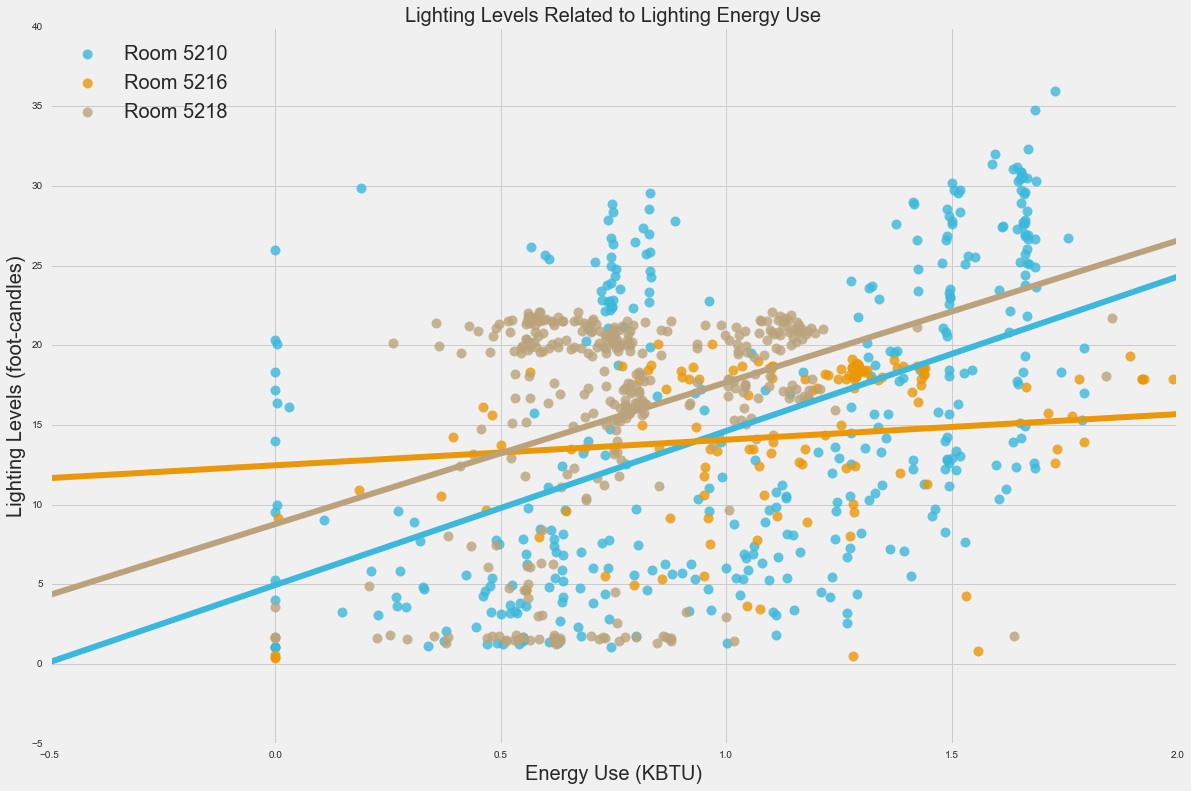

In [40]:
plt.style.use("fivethirtyeight")
lightScatterFig = plt.figure(figsize = (18,12))

sns.regplot(x = lightScatter5210[(lightScatter5210["School Day"] == 1) & 
                                 (lightScatter5210["School Hours"] == 1)]["KBTU"],
                            y = lightScatter5210[(lightScatter5210["School Day"] == 1) & 
                                                 (lightScatter5210["School Hours"] == 1)]["Illum"], 
                            color = "#3bb8db", label = "Room 5210", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = lightScatter5216[(lightScatter5216["School Day"] == 1) & 
                                 (lightScatter5216["School Hours"] == 1)].ix["2016-11-09":]["KBTU"],
                            y = lightScatter5216[(lightScatter5216["School Day"] == 1) &
                                                 (lightScatter5216["School Hours"] == 1)].ix["2016-11-09":]["Illum"], 
                            color = "#ea9809", label = "Room 5216", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = lightScatter5218[(lightScatter5218["School Day"] == 1) & 
                                 (lightScatter5218["School Hours"] == 1)]["KBTU"],
                            y = lightScatter5218[(lightScatter5218["School Day"] == 1) & 
                                                 (lightScatter5218["School Hours"] == 1)]["Illum"], 
                            color = "#baa37c", label = "Room 5218", scatter_kws={'s':100}, ci = 0)

# sns.ylim((0,40))
plt.xlabel("Energy Use (KBTU)", fontdict = {"size" : 20})
plt.ylabel("Lighting Levels (foot-candles)", fontdict = {"size" : 20})
plt.title("Lighting Levels Related to Lighting Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

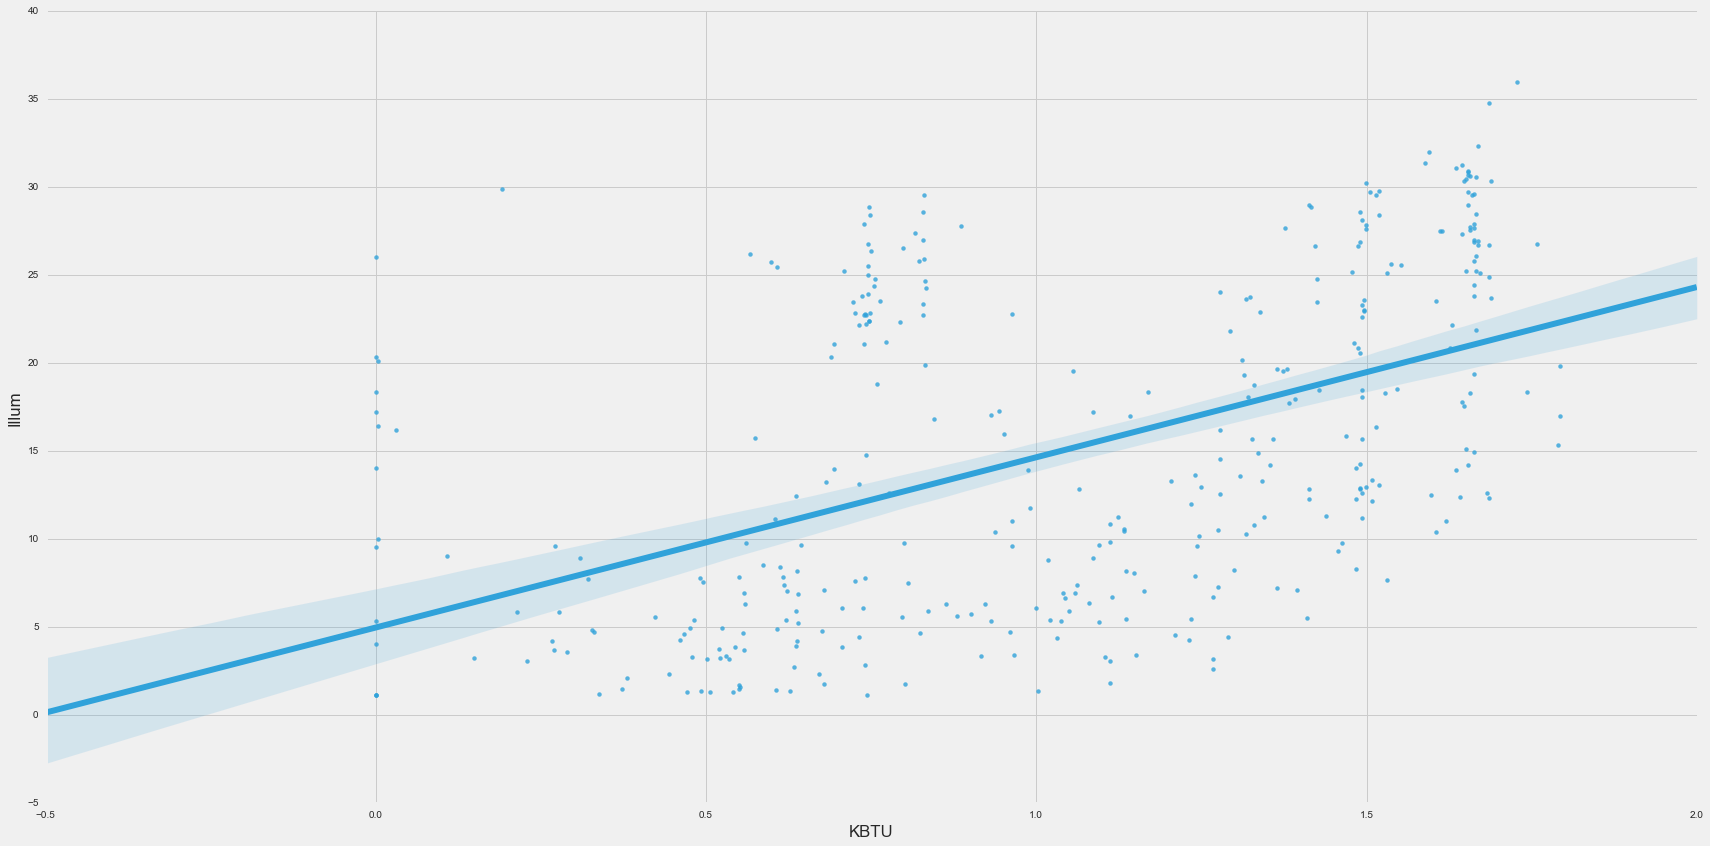

In [54]:
sns.lmplot(data = lightScatter5210[(lightScatter5210["School Day"] == 1) & 
                                 (lightScatter5210["School Hours"] == 1)], x = "KBTU", y = "Illum", size = 12, aspect = 2)

In [76]:
from sklearn.linear_model import LinearRegression

test = lightScatter5210[(lightScatter5210["School Day"] == 1) & 
                                 (lightScatter5210["School Hours"] == 1)][["KBTU", "Illum"]].dropna()
X = test[["KBTU"]]
y = test[["Illum"]]

lm = LinearRegression()
algo = lm.fit(X,y)
print("Coefficients: ", algo.coef_)
print("Y Intercept:", algo.intercept_)
print("R-Squared: ", algo.score(X,y))

Coefficients:  [[ 9.67039518]]
Y Intercept: [ 4.96088546]
R-Squared:  0.246539854298


In [77]:
test =  lightScatter5216[(lightScatter5216["School Day"] == 1) & 
                                 (lightScatter5216["School Hours"] == 1)].ix["2016-11-09":][["KBTU", "Illum"]]
X = test[["KBTU"]]
y = test[["Illum"]]

lm = LinearRegression()
algo = lm.fit(X,y)
print("Coefficients: ", algo.coef_)
print("Y Intercept:", algo.intercept_)
print("R-Squared: ", algo.score(X,y))

Coefficients:  [[ 1.60436702]]
Y Intercept: [ 12.477049]
R-Squared:  0.0513723293102


In [79]:
test =  lightScatter5218[(lightScatter5218["School Day"] == 1) & 
                                 (lightScatter5218["School Hours"] == 1)][["KBTU", "Illum"]]
X = test[["KBTU"]]
y = test[["Illum"]]

lm = LinearRegression()
algo = lm.fit(X,y)
print("Coefficients: ", algo.coef_)
print("Y Intercept:", algo.intercept_)
print("R-Squared: ", algo.score(X,y))

Coefficients:  [[ 8.89182248]]
Y Intercept: [ 8.78635045]
R-Squared:  0.112124687169


In [67]:
algo.predict(2)

array([[ 24.30167582]])

In [65]:
import statsmodels.formula.api as smf
st = smf.ols(formula='y ~ X', data=test).fit()
st.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     119.1
Date:                Wed, 01 Mar 2017   Prob (F-statistic):           3.52e-24
Time:                        16:02:38   Log-Likelihood:                -1283.4
No. Observations:                 366   AIC:                             2571.
Df Residuals:                     364   BIC:                             2579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.9609      1.024      4.847      0.000         2.948     6.974
X              9.6704      0.886     10.914      0.000         7.928    11.413
==============================================================================
Omnibus:                       60.282   Durbin-Watson:                   0.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.425
Skew:                           0.386   Prob(JB):                     1.35e-05
Kurtosis:                       2.065   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
st.predict(pd.DataFrame(data = [2], columns = ["X"]))

array([ 24.30167582])

### Circuit Energy Use/SqFt vs Illuminance

In [264]:
# ahuTotal = pd.DataFrame(energy[energy["ID"] == "Air Handling Unit"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
panel9 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 9"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())
panel15 = pd.DataFrame(energy[energy["ID"] == "Lighting Panel 15"]["kWh"].groupby(pd.TimeGrouper(freq = "1H")).sum())

# sqftAHU = 102 + 118 + 825 + 410
sqftPanel9 = 477 + 102 + 118 + 825
sqftPanel15 = 215 + 228 + 170 + 59 + 61 + 410 + 512 + 50 + 58 + 185

# ahuTotal["KBTU/Sqft"] = (ahuTotal["kWh"] * 3.4121416331) / sqftAHU
panel9["KBTU/Sqft"] = (panel9["kWh"] * 3.4121416331) / sqftPanel9
panel15["KBTU/Sqft"] = (panel15["kWh"] * 3.4121416331) / sqftPanel15

In [282]:
avgIllum5210 = pd.DataFrame(illum5210.groupby(pd.TimeGrouper(freq = "1H"))["Illum"].mean())
avgIllum5216 = pd.DataFrame(illum5216.groupby(pd.TimeGrouper(freq = "1H"))["Illum"].mean())
avgIllum5218 = pd.DataFrame(illum5218.groupby(pd.TimeGrouper(freq = "1H"))["Illum"].mean())

illumScatter5210 = avgIllum5210.join(panel9, how = "inner").dropna()
illumScatter5216 = avgIllum5216.join(panel9, how = "inner").dropna()
illumScatter5218 = avgIllum5218.join(panel15, how = "inner").dropna()

for x in [illumScatter5210, illumScatter5216, illumScatter5218]:
    daysoff(x)

In [443]:
# Create binary column indicating whether or not either one of the lights in the room were on 
# for over 40 minutes in the hour

lights = []
for x in eitherLight5216["Hour"]:
    if x >= 8 and x <= 14:
        lights.append(1)
    else:
        lights.append(0)

eitherLight5216["40+ of Light"] = lights

In [448]:
# illumScatter5210 = illumScatter5210.join(eitherLight5210.dropna(), how = "inner")
illumScatter5216 = illumScatter5216.join(eitherLight5216[["Either Light On", "40+ of Light"]], how = "inner")
# illumScatter5218 = illumScatter5218.join(eitherLight5218.dropna(), how = "inner")

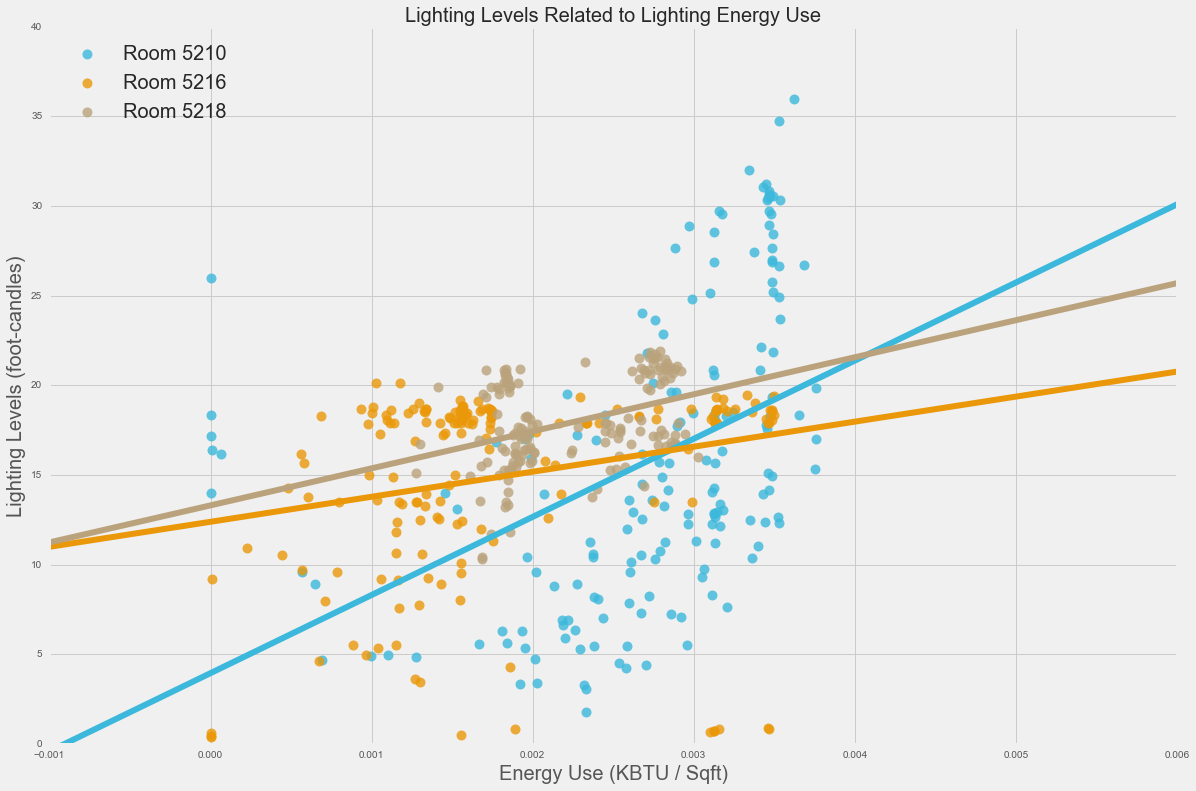

In [450]:
plt.style.use("fivethirtyeight")
lightScatterFig = plt.figure(figsize = (18,12))

sns.regplot(x = illumScatter5210[(illumScatter5210["School Day"] == 1) & 
                                 (illumScatter5210["School Hours"] == 1) &
                                 (illumScatter5210["40+ of Light"] == 1)]["KBTU/Sqft"],
                            y = illumScatter5210[(illumScatter5210["School Day"] == 1) & 
                                                 (illumScatter5210["School Hours"] == 1) &
                                                 (illumScatter5210["40+ of Light"] == 1)]["Illum"], 
                            color = "#3bb8db", label = "Room 5210", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = illumScatter5216[(illumScatter5216["School Day"] == 1) & 
                                 (illumScatter5216["School Hours"] == 1) &
                                 (illumScatter5216["40+ of Light"] == 1)]["KBTU/Sqft"].ix["2016-11-09":],
                            y = illumScatter5216[(illumScatter5216["School Day"] == 1) &
                                                 (illumScatter5216["School Hours"] == 1) &
                                                 (illumScatter5216["40+ of Light"] == 1)]["Illum"].ix["2016-11-09":], 
                            color = "#ea9809", label = "Room 5216", scatter_kws={'s':100}, ci = 0)

sns.regplot(x = illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                                 (illumScatter5218["School Hours"] == 1) &
                                 (illumScatter5218["40+ of Light"] == 1)]["KBTU/Sqft"],
                            y = illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                                                 (illumScatter5218["School Hours"] == 1) &
                                                 (illumScatter5218["40+ of Light"] == 1)]["Illum"], 
                            color = "#baa37c", label = "Room 5218", scatter_kws={'s':100}, ci = 0)

sns.plt.ylim(0,40)
sns.plt.xlim(-.001,.006)
plt.xlabel("Energy Use (KBTU / Sqft)", fontdict = {"size" : 20})
plt.ylabel("Lighting Levels (foot-candles)", fontdict = {"size" : 20})
plt.title("Lighting Levels Related to Lighting Energy Use", fontdict = {"size" : 20})
plt.legend(loc = 2, prop = {'size' : 20})

In [576]:
# Calculate the percentage of time spent within the lighting panel thresholds

holder = illumScatter5216[(illumScatter5216["School Day"] == 1) & 
                                 (illumScatter5216["School Hours"] == 1) &
                                 (illumScatter5216["40+ of Light"] == 1)].ix["2016-11-09":]["KBTU/Sqft"]

count = len(holder)
low = 0
mid = 0
high = 0
for x in holder:
    if x < .002:
        low += 1
    elif x > .004:
        high += 1
    elif x >= .002 and x <= .004:
        mid += 1

print("5216")
print("Low: ", (low/count))
print("Mid: ", (mid/count))
print("High: ", (high/count))

print(low, mid, high)

5216
Low:  0.7005649717514124
Mid:  0.2994350282485876
High:  0.0
124 53 0


In [480]:
# Calculate the percentage of time spent within the lighting panel thresholds

count = len(illumScatter5210[(illumScatter5210["School Day"] == 1) & 
                           (illumScatter5210["School Hours"] == 1) &
                           (illumScatter5210["40+ of Light"])]["Illum"].dropna())
cold = 0
ok = 0
hot = 0
for x in illumScatter5210[(illumScatter5210["School Day"] == 1) & 
                           (illumScatter5210["School Hours"] == 1) &
                           (illumScatter5210["40+ of Light"])]["Illum"].dropna():
    if x < 7:
        cold += 1
    elif x > 14:
        hot += 1
    elif x <= 14 and x >= 7:
        ok += 1

print("5210")
print(count)
print("Inadequate: ", (cold/count))
print("Ok for Writing: ", (ok/count))
print("Ok for Witeboard: ", (hot/count))

5210
171
Inadequate:  0.15789473684210525
Ok for Writing:  0.3216374269005848
Ok for Witeboard:  0.52046783625731


In [477]:
# Calculate the percentage of time spent within specified illuminance thresholds

count = len(illumScatter5216[(illumScatter5216["School Day"] == 1) & 
                           (illumScatter5216["School Hours"] == 1) &
                           (illumScatter5216["40+ of Light"])]["Illum"].dropna())
cold = 0
ok = 0
hot = 0
for x in illumScatter5216[(illumScatter5216["School Day"] == 1) & 
                           (illumScatter5216["School Hours"] == 1) &
                           (illumScatter5216["40+ of Light"])]["Illum"].dropna():
    if x < 7:
        cold += 1
    elif x > 14:
        hot += 1
    elif x <= 14 and x >= 7:
        ok += 1

print("5216")
print(count)
print("Inadequate: ", (cold/count))
print("Ok for Writing: ", (ok/count))
print("Ok for Witeboard: ", (hot/count))

5216
334
Inadequate:  0.5209580838323353
Ok for Writing:  0.12574850299401197
Ok for Witeboard:  0.3532934131736527


In [478]:
# Calculate the percentage of time spent within specified illuminance thresholds

count = len(illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                           (illumScatter5218["School Hours"] == 1) &
                           (illumScatter5218["40+ of Light"])]["Illum"].dropna())
cold = 0
ok = 0
hot = 0
for x in illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                           (illumScatter5218["School Hours"] == 1) &
                           (illumScatter5218["40+ of Light"])]["Illum"].dropna():
    if x < 7:
        cold += 1
    elif x > 14:
        hot += 1
    elif x <= 14 and x >= 7:
        ok += 1

print("5218")
print(count)
print("Inadequate: ", (cold/count))
print("Ok for Writing: ", (ok/count))
print("Ok for Witeboard: ", (hot/count))

5218
157
Inadequate:  0.0
Ok for Writing:  0.05732484076433121
Ok for Witeboard:  0.9426751592356688


In [487]:
# Calculate the percentage of time spent within the lighting panel thresholds

count = len(illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                           (illumScatter5218["School Hours"] == 1) &
                           (illumScatter5218["40+ of Light"])]["KBTU/Sqft"].dropna())
cold = 0
ok = 0
hot = 0
for x in illumScatter5218[(illumScatter5218["School Day"] == 1) & 
                           (illumScatter5218["School Hours"] == 1) &
                           (illumScatter5218["40+ of Light"])]["KBTU/Sqft"].dropna():
    if x < .002:
        cold += 1
    elif x > .004:
        hot += 1
    elif x <= .004 and x >= .002:
        ok += 1

print("5218")
print(count)
print("Inadequate: ", (cold/count))
print("Ok for Writing: ", (ok/count))
print("Ok for Witeboard: ", (hot/count))

5218
157
Inadequate:  0.5031847133757962
Ok for Writing:  0.4968152866242038
Ok for Witeboard:  0.0


In [454]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Two")
illumScatter5210.to_excel("Illum vs Lighting Energy 5210.xlsx")
illumScatter5216.to_excel("Illum vs Lighting Energy 5216.xlsx")
illumScatter5218.to_excel("Illum vs Lighting Energy 5218.xlsx")

In [51]:
# R squared values of the illuminance and KBTU relationships

print("5210 Illum vs Light Energy: ", stats.linregress(
        x = lightScatter5210[(lightScatter5210["School Day"] == 1) & (lightScatter5210["School Hours"] == 1)]["KBTU"], 
        y = lightScatter5210[(lightScatter5210["School Day"] == 1) & (lightScatter5210["School Hours"] == 1)]["Illum"])[2]**2)
print(" ")
print("5216 Illum vs Light Energy: ", stats.linregress(
        x = lightScatter5216[(lightScatter5216["School Day"] == 1) & (lightScatter5216["School Hours"] == 1)].ix["2016-11-09":]["KBTU"], 
        y = lightScatter5216[(lightScatter5216["School Day"] == 1) & (lightScatter5216["School Hours"] == 1)].ix["2016-11-09":]["Illum"])[2]**2)
print(" ")
print("5218 Illum vs Light Energy: ", stats.linregress(
        x = lightScatter5218[(lightScatter5218["School Day"] == 1) & (lightScatter5218["School Hours"] == 1)]["KBTU"], 
        y = lightScatter5218[(lightScatter5218["School Day"] == 1) & (lightScatter5218["School Hours"] == 1)]["Illum"])[2]**2)

5210 Illum vs Light Energy:  0.246539854298
 
5216 Illum vs Light Energy:  0.0513723293102
 
5218 Illum vs Light Energy:  0.112124687169


### Data Investigation

### Look into Three Distinct Air Handling Unit Energy Unit Levels by Hour

#### 5216

In [418]:
timeValues(scatter5216)

In [417]:
holder = pd.DataFrame(index = range(0,24))

In [377]:
holder = holder.join(scatter5216[(scatter5216["School Day"] == 1) &
            (scatter5216["School Hours"] == 1) &
            (scatter5216["KBTU"] <= .5)].groupby("Hour")["KBTU"].count())

holder.columns = ["Less Than .5"]

In [379]:
holder = holder.join(scatter5216[(scatter5216["School Day"] == 1) &
            (scatter5216["School Hours"] == 1) &
            (scatter5216["KBTU"] <= 2) &
            (scatter5216["KBTU"] >= 1.5)].groupby("Hour")["KBTU"].count())

holder.columns = ["<.5", "1.5 - 2"]

In [381]:
holder = holder.join(pd.DataFrame(scatter5216[(scatter5216["School Day"] == 1) &
            (scatter5216["School Hours"] == 1) &
            (scatter5216["KBTU"] <= 4) &
            (scatter5216["KBTU"] >= 3.5)].groupby("Hour")["KBTU"].count()))

holder.columns = ["<.5", "1.5 - 2", "3.5 - 4"]

holder.fillna(0, inplace = True)

In [405]:
holder.iplot(kind = "bar", xTitle = "Hours", yTitle = "Count", 
             title = "Room 5216 Count of AHU Setting During Hour")

In [403]:
timeValues(scatter5218)
holder5218 = pd.DataFrame(index = range(0,24))

holder5218 = holder5218.join(scatter5218[(scatter5218["School Day"] == 1) &
            (scatter5218["School Hours"] == 1) &
            (scatter5218["KBTU"] <= .5)].groupby("Hour")["KBTU"].count())

holder5218.columns = ["<.5"]

holder5218 = holder5218.join(scatter5218[(scatter5218["School Day"] == 1) &
            (scatter5218["School Hours"] == 1) &
            (scatter5218["KBTU"] <= 1) &
            (scatter5218["KBTU"] >= .5)].groupby("Hour")["KBTU"].count())

holder5218.columns = ["<.5", "1.5 - 2"]

holder5218 = holder5218.join(pd.DataFrame(scatter5218[(scatter5218["School Day"] == 1) &
            (scatter5218["School Hours"] == 1) &
            (scatter5218["KBTU"] <= 2) &
            (scatter5218["KBTU"] >= 1.5)].groupby("Hour")["KBTU"].count()))

holder5218.columns = ["<.5", "1.5 - 2", "3.5 - 4"]

holder5218.fillna(0, inplace = True)


In [406]:
holder5218.iplot(kind = "bar", xTitle = "Hours", yTitle = "Count", 
             title = "Room 5218 Count of AHU Setting During Hour")

In [723]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Question Two")
# scatter5216.to_excel("Thermal Comfort vs AHU 5216.xlsx")
# scatter5218.to_excel("Thermal Comfort vs AHU 5218.xlsx")

# airScatter5216.to_excel("Air Quality vs AHU 5216.xlsx")
# airScatter5218.to_excel("Air Quality vs AHU 5218.xlsx")

# lightScatter5210.to_excel("Illum vs Lighting Energy 5210.xlsx")
# lightScatter5216.to_excel("Illum vs Lighting Energy 5216.xlsx")
# lightScatter5218.to_excel("Illum vs Lighting Energy 5218.xlsx")

# holder.to_excel("Count of AHU Set Point by Hour 5216.xlsx")
# holder5218.to_excel("Count of AHU Set Point by Hour 5218.xlsx")

energyAirQuality.to_excel("Energy vs Air Quality.xlsx")

In [603]:
os.chdir("/Users/adeniyiharrison/Desktop")
pmvScatterFig.savefig("PMV vs AHU Scatter Plot.pdf")
airScatterFig.savefig("CO2 vs AHU Scatter Plot.pdf")
lightScatterFig.savefig("Illuminance vs Light Energy.pdf")